In [1]:
from models import preflop_model

model = preflop_model()
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 3,730
Trainable params: 3,730
Non-trainable params: 0
_________________________________________________________________


In [2]:
from engine import Engine
from treys import Card
import numpy as np
from constants import Actions

engine = Engine()


In [ ]:
num_hands = 25000
total_reward = 0

e = 0.1
loss = []

sb_pushed_plt = []
bb_called_plt = []

state_sb = np.zeros((16))
state_bb = np.zeros((16))

targetQ = np.zeros((2))

bankroll_sb = [0]
player1 = True

replay_state = []
replay_Q = []
max_replay = 3000

sb_pushed = 0
bb_called = 0


for i in range(num_hands):
    reward_sb = 0
    reward_bb = 0

  
    engine.new_hand(starting_stack=np.random.randint(40,400))

    sb_features = np.concatenate([engine.get_pocket_cards_features(0),np.array([engine.has_suited_pockets(0),1,engine.starting_stack/400])]).reshape((1,16))
    bb_features = np.concatenate([engine.get_pocket_cards_features(1),np.array([engine.has_suited_pockets(1),0,engine.starting_stack/400])]).reshape((1,16))

    replay_state.append(sb_features.reshape((16,)))
    
    
    #run model to choose action
    allQ_sb = model.predict(sb_features)
    action_sb = np.argmax(allQ_sb)
    allQ_bb = model.predict(bb_features)
    action_bb = np.argmax(allQ_bb)

    #randomly discover new line
    if(np.random.rand(1) < e):

        action_sb = np.random.randint(0,2)
        action_bb = np.random.randint(0,2)
        

    if action_sb == 1:
        sb_pushed +=1
        engine.play_action(Actions.BET,engine.get_bet_range()[1])
    
        
        if action_bb == 1:
            bb_called +=1
            engine.play_action(Actions.CALL, 0)  
        else:
            engine.play_action(Actions.FOLD,0)

    else:
        engine.play_action(Actions.FOLD,0)
    

    if engine.winner != -1:
        r = engine.get_sb_won()

    else:
        print('not fichished walla')
    total_reward +=r
    bankroll_sb.append(bankroll_sb[-1]+r)
    
    allQ_sb[0,action_sb] = r
    replay_Q.append(allQ_sb.reshape((2,)))
    
    #train only if sb played. otherwise positive reward for folding
    if action_sb == 1:
        replay_state.append(bb_features.reshape((16,)))
        allQ_bb[0,action_bb] = -r
        replay_Q.append(allQ_bb.reshape((2,)))
    
    if(i%500 == 0 and i > 0):
        print(i)

    if(i%1000== 0 and i > 0):
        sb_pushed_pct = int(sb_pushed/(i+1)*100)
        sb_pushed_plt.append(sb_pushed_pct)
        bb_called_pct = int(bb_called/(sb_pushed+1)*100)
        bb_called_plt.append(bb_called_pct)
        print('\n\nround',i)
        print('Won(SB):',r,'  Total won (SB):',total_reward)
        print('SB pushed ' + str(sb_pushed_pct)+'% , BB called '+  str(bb_called_pct)+'%' )
        print('sb_features')
        print(sb_features)
        print('allQ_sb:')
        print(allQ_sb)
        print('\nbb_features')
        print(bb_features)
        print('allQ_bb:')   
        print(allQ_bb)
        
                
        model.fit(np.stack(replay_state),np.stack(replay_Q),verbose=1,epochs=5)


    if(len(replay_state) > max_replay):
        replay_state = replay_state[50:]
        replay_Q = replay_Q[50:]


500
1000


round 1000
Won(SB): -10   Total won (SB): -3693
SB pushed 84% , BB called 29%
sb_features
[[ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.
   1.    1.    0.89]]
allQ_sb:
[[-10.         -11.64652824]]

bb_features
[[ 0.    1.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
   0.    0.    0.89]]
allQ_bb:
[[-21.46174049 -86.01194   ]]
Epoch 1/5
1850/1850 [==============================] - 1s 290us/step - loss: 5672.6792
Epoch 2/5
1850/1850 [==============================] - 0s 269us/step - loss: 5605.5565
Epoch 3/5
1850/1850 [==============================] - 1s 339us/step - loss: 5545.1691
Epoch 4/5
1850/1850 [==============================] - 0s 270us/step - loss: 5511.5311
Epoch 5/5
1850/1850 [==============================] - 0s 269us/step - loss: 5483.3903
1500
2000


round 2000
Won(SB): -10   Total won (SB): 2584
SB pushed 83% , BB called 31%
sb_features
[[ 0.      0.      1.      0.      0.      0.      1.      0.      0.   

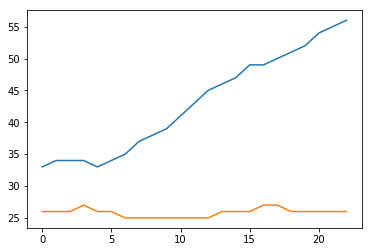

In [9]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(sb_pushed_plt[1:])
plt.plot(bb_called_plt[1:])

In [10]:
from metrics import compute_nash_pusher
from metrics import compute_nash_caller
call_nash = compute_nash_caller(model)
push_chart = compute_nash_pusher(model)

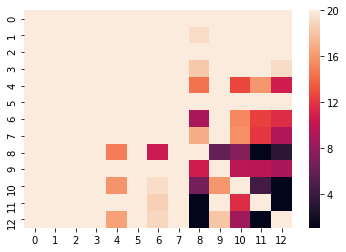

In [11]:
sns.heatmap(push_chart)

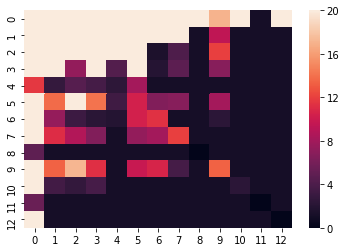

In [12]:
sns.heatmap(call_nash)

In [13]:
call_nash


array([[ 20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,
         17.1,  20. ,   1.1,  20. ],
       [ 20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,   1.1,
          9.4,   1.1,   1.1,   1.1],
       [ 20. ,  20. ,  20. ,  20. ,  20. ,  20. ,   1.5,   4.1,   1.1,
         12. ,   1.1,   1.1,   1.1],
       [ 20. ,  20. ,   7.4,  20. ,   4.3,  20. ,   2. ,   4.8,   1.1,
          6.8,   1.1,   1.1,   1.1],
       [ 11.7,   2.8,   4.5,   3.6,   2.4,   8.2,   1.1,   1.1,   1.1,
          1.1,   1.1,   1.1,   1.1],
       [ 20. ,  13.8,  20. ,  14.1,   3.3,  10.4,   6.5,   6.8,   1.1,
          8.2,   1.1,   1.1,   1.1],
       [ 20. ,   7.5,   3.2,   2.2,   1.9,  10.4,  11.4,   1.1,   1.1,
          2.3,   1.1,   1.1,   1.1],
       [ 20. ,  11.1,   8.8,   6.5,   1.1,   7.4,   8.1,  12. ,   1.1,
          1.1,   1.1,   1.1,   1.1],
       [  4.9,   1.1,   1.1,   1.1,   1.1,   1.1,   1.1,   1.1,   0. ,
          1.1,   1.1,   1.1,   1.1],
       [ 20. ,  13.4,  17.2,

In [ ]:
from models import save_model

save_model(model,'pushfold4')

In [ ]:
from models import load

model = load('pushfold')